MLP model for predicting filtered shear stress and TTF using {A_filt, V_filt, T_pc, Vel_pc} and a new feature: spectral frequency {maxFreqI_filt}

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time

from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input
from keras.utils import plot_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix-1, -2:]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2),  'SS':data['SS'].ravel(), 'TTF':data['TTF'].ravel()})  
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 'T_der':data['T_der'].ravel(), 'Vel_der':data['Vel_der'].ravel()}) 
df = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel()})

df = pd.concat([df, df2], axis=1)

df = df[['A_filt', 'V_filt', 'T_pc', 'Vel_pc', 'maxFreqI_filt', 'SS', 'TTF']]
print("Input data:\n", df)

Input data:
              A_filt       V_filt  T_pc  Vel_pc  maxFreqI_filt        SS  TTF
0       1804.180000  5489.978529   0.0     0.0  457680.400524  5.656166  0.0
1       1803.666667  5489.981454   0.0     0.0  457727.638932  5.657157  0.0
2       1803.314286  5489.997639   0.0     0.0  457770.778724  5.658317  0.0
3       1803.437500  5490.007016   0.0     0.0  457811.889181  5.659499  0.0
4       1803.266667  5490.000189   0.0     0.0  457775.514596  5.660404  0.0
...             ...          ...   ...     ...            ...       ...  ...
132394  1784.250000  5459.380488   0.0     0.0  454414.128118  5.471059  0.0
132395  1784.055556  5459.377762   0.0     0.0  454404.028108  5.474545  0.0
132396  1783.837500  5459.388352   0.0     0.0  454403.709700  5.478286  0.0
132397  1783.371429  5459.398820   0.0     0.0  454398.871858  5.481751  0.0
132398  1781.433333  5459.399041   0.0     0.0  454410.333590  5.484813  0.0

[132399 rows x 7 columns]


In [4]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132100, 300, 5)
Target shape, Y =  (132100, 2)
After reshaping, X =  (132100, 1500)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 95112
Validation samples: 10568
Testing samples: 26420


Epoch 1/30
2973/2973 [==============================] - 9s 3ms/step - loss: 0.2730 - ss_loss: 0.1309 - ttf_loss: 0.2843 - val_loss: 0.1828 - val_ss_loss: 0.0761 - val_ttf_loss: 0.2136
Epoch 2/30
2973/2973 [==============================] - 9s 3ms/step - loss: 0.0999 - ss_loss: 0.0403 - ttf_loss: 0.1193 - val_loss: 0.1025 - val_ss_loss: 0.0417 - val_ttf_loss: 0.1216
Epoch 3/30
2973/2973 [==============================] - 9s 3ms/step - loss: 0.0775 - ss_loss: 0.0246 - ttf_loss: 0.1058 - val_loss: 0.1098 - val_ss_loss: 0.0544 - val_ttf_loss: 0.1108
Epoch 4/30
2973/2973 [==============================] - 9s 3ms/step - loss: 0.0596 - ss_loss: 0.0127 - ttf_loss: 0.0937 - val_loss: 0.0996 - val_ss_loss: 0.0144 - val_ttf_loss: 0.1703
Epoch 5/30
2973/2973 [==============================] - 9s 3ms/step - loss: 0.0491 - ss_loss: 0.0054 - ttf_loss: 0.0874 - val_loss: 0.1045 - val_ss_loss: 0.0064 - val_ttf_loss: 0.1962
Epoch 6/30
2973/2973 [==============================] - 9s 3ms/step - loss: 0.04

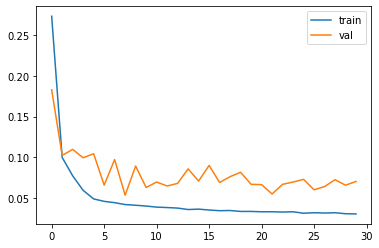

---Training time: 265.23188496 seconds ---


In [6]:
# Build the model

np.random.seed(0)   # To get reproducible results
tf.random.set_seed(0)

out_dim = ydf.shape[1]

inp = Input(shape=in_dim, name='inp')
m = Dense(512, kernel_initializer = 'normal', activation='relu')(inp)
m = Dense(256, kernel_initializer = 'normal', activation='relu')(m)
m = Dense(32, kernel_initializer = 'normal', activation='relu')(m)
ss = Dense(1, kernel_initializer = 'normal', activation='linear', name='ss')(m)
ttf = Dense(1, kernel_initializer = 'normal', activation='linear', name='ttf')(m)
model = Model(inputs=[inp], outputs=[ss,ttf])

losses = {'ss': 'mse', 'ttf':'mse'}
losswts = {'ss': 1.0, 'ttf': 0.5}

model.compile(loss=losses, loss_weights=losswts, optimizer='adam')

start_time = time.time()
history = model.fit(X_train, {'ss':Y_train[:,0], 'ttf':Y_train[:,1]}, epochs=30, batch_size=32, 
                    validation_data=(X_val, {'ss':Y_val[:,0], 'ttf':Y_val[:,1]}), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [7]:
# Evaluate the model

y_predTrain = model.predict(X_train)
y_predTrain[1] = np.clip(y_predTrain[1].ravel(), a_min=0,a_max=None)
ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[0]))
ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[1]))

y_predVal = model.predict(X_val)
y_predVal[1] = np.clip(y_predVal[1].ravel(), a_min=0,a_max=None)
ss_val_r2 = r2_score(Y_val[:,0], y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[0]))  
ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[1]))

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
y_predTest[1] = np.clip(y_predTest[1].ravel(), a_min=0,a_max=None)
ss_test_r2 = r2_score(y_test[:,0], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[0]))
ttf_test_r2 = r2_score(y_test[:,1], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[1]))

print("Shear Stress\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_r2, ss_val_r2, ss_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_rmse, ss_val_rmse, ss_test_rmse))

print("\nTTF\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_r2, ttf_val_r2, ttf_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_rmse, ttf_val_rmse, ttf_test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

Shear Stress
R2 scores: Train - 0.93120, Validation - 0.92368, Test - 0.87124
RMSE scores: Train - 0.03372, Validation - 0.04076, Test - 0.05185

TTF
R2 scores: Train - 0.94450, Validation - 0.89641, Test - 0.85107
RMSE scores: Train - 0.24693, Validation - 0.37101, Test - 0.44316

---Time for Test data prediction: 0.91358328 seconds ---


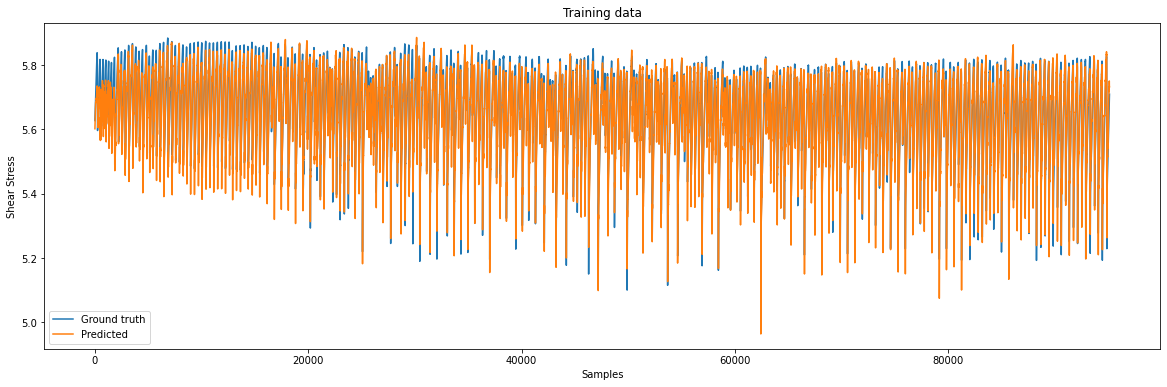

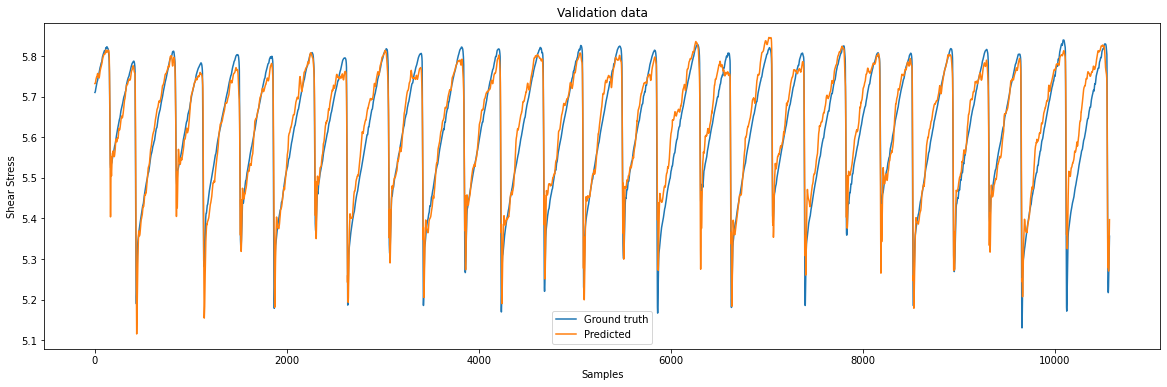

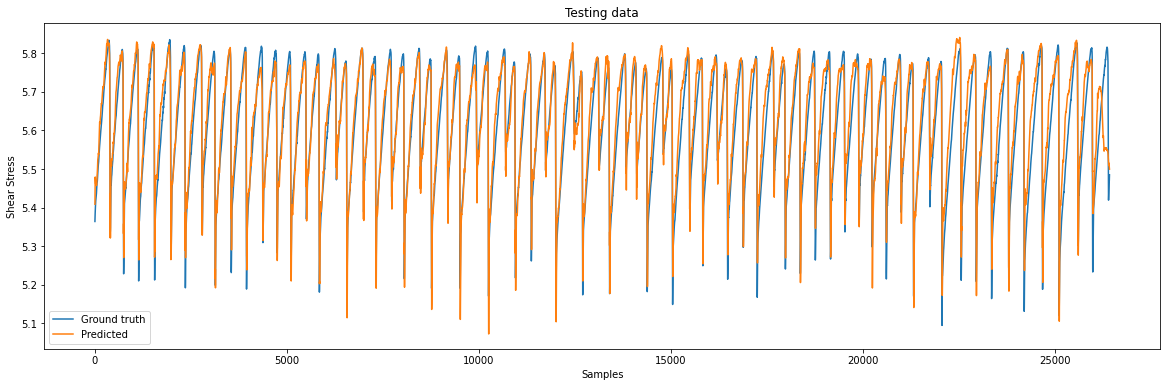

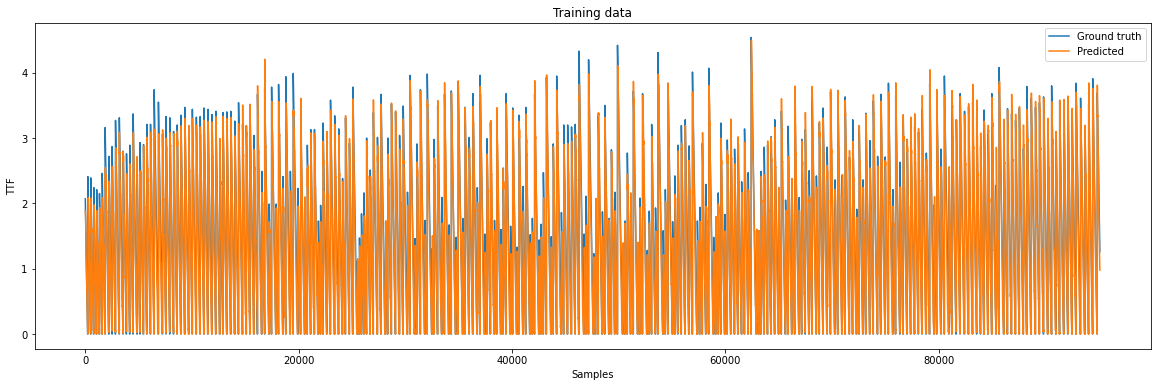

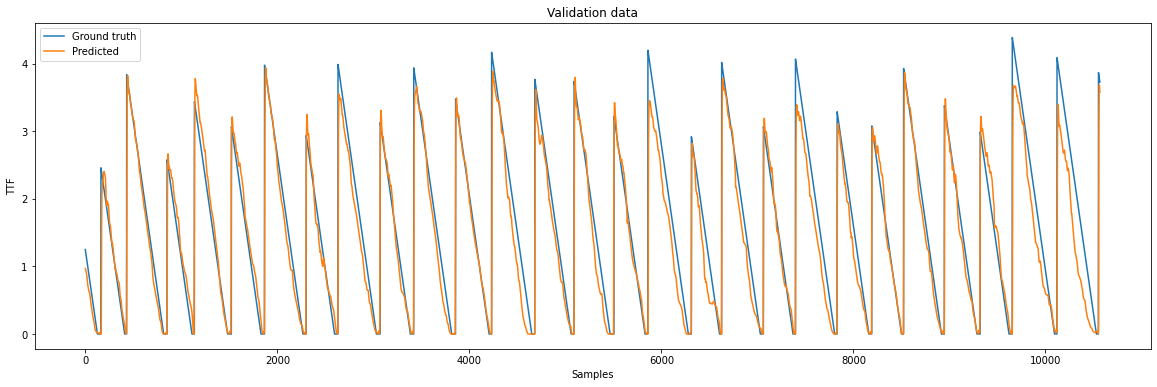

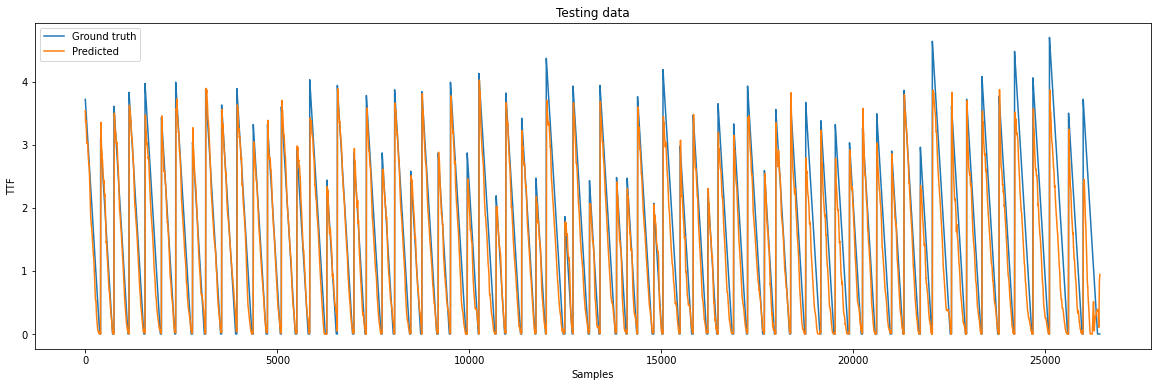

In [8]:
# Results plot

def results_plot(fig_no, gt, pred, title, ylabel):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel(ylabel)
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train[:,0], y_predTrain[0], 'Training data', 'Shear Stress')
results_plot(2, Y_val[:,0], y_predVal[0], 'Validation data', 'Shear Stress')
results_plot(3, y_test[:,0], y_predTest[0], 'Testing data', 'Shear Stress')
results_plot(4, Y_train[:,1], y_predTrain[1], 'Training data', 'TTF')
results_plot(5, Y_val[:,1], y_predVal[1], 'Validation data', 'TTF')
results_plot(6, y_test[:,1], y_predTest[1], 'Testing data', 'TTF')

Text(0.5, 1.0, 'Detailed View, Testing Data')

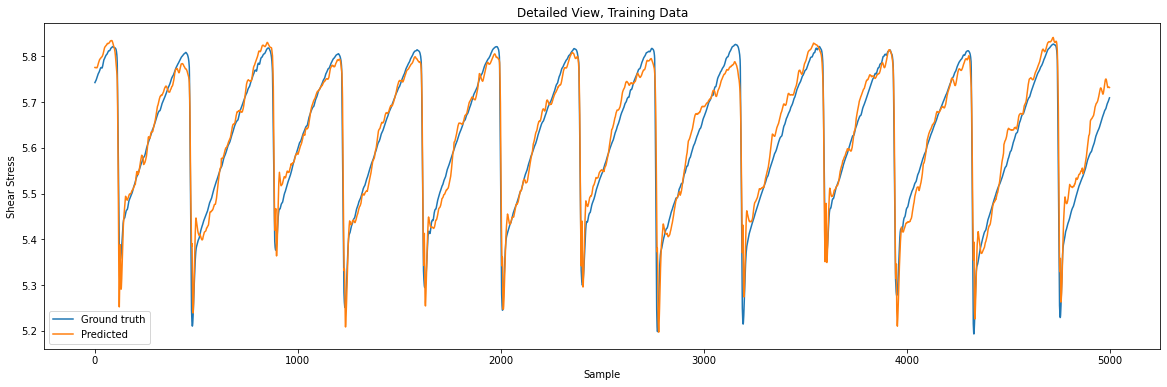

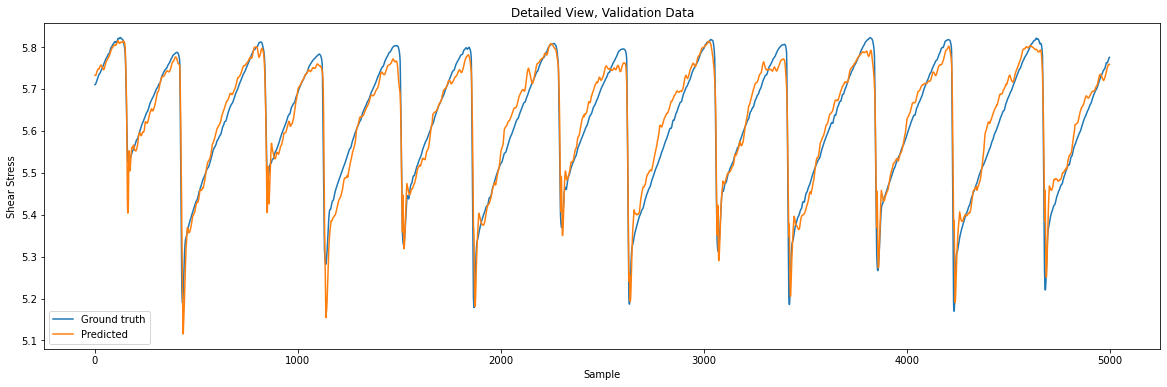

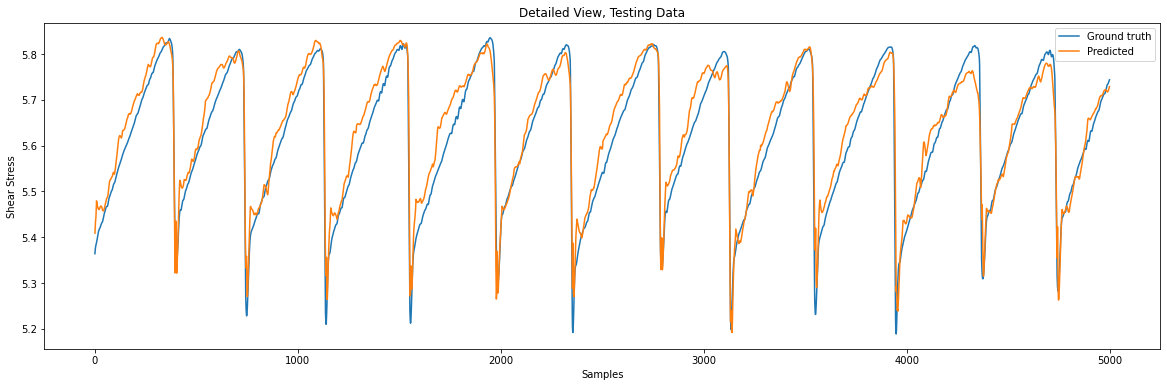

In [9]:
# Detailed view of SS plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:,0])
plt.plot(y_predTrain[0][-n:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n,0])
plt.plot(y_predVal[0][:n])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n,0])
plt.plot(y_predTest[0][:n])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'Detailed View, Testing Data')

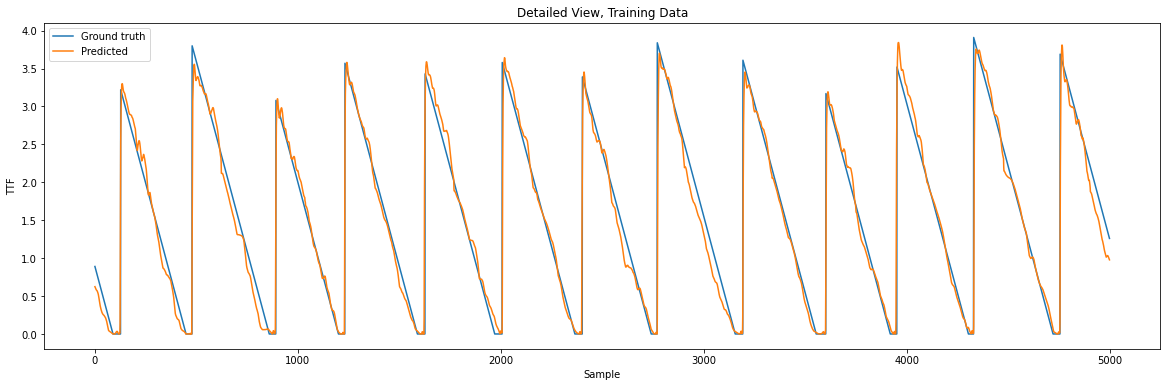

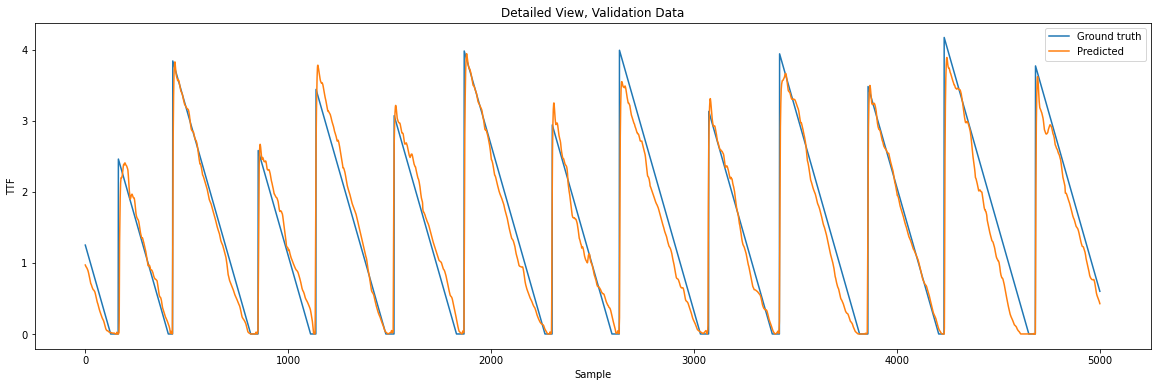

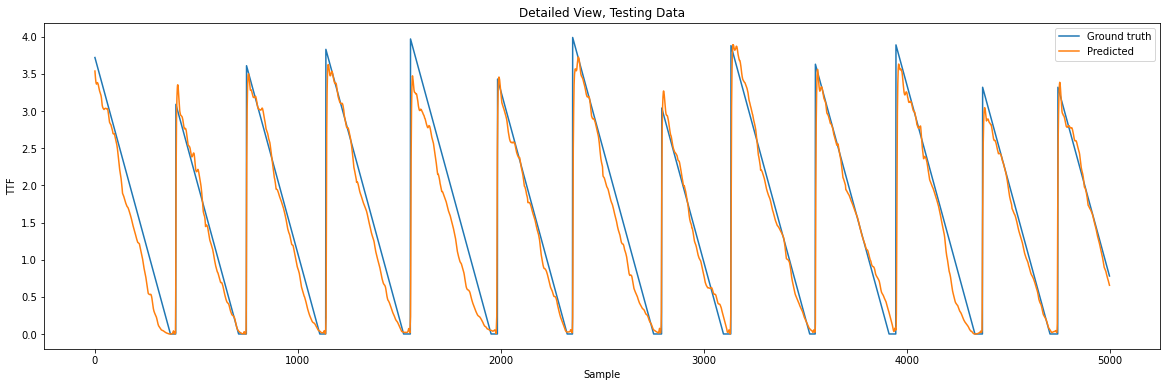

In [10]:
# Detailed view of TTF plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:,1])
plt.plot(y_predTrain[1][-n:])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n,1])
plt.plot(y_predVal[1][:n])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n,1])
plt.plot(y_predTest[1][:n])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'TTF')

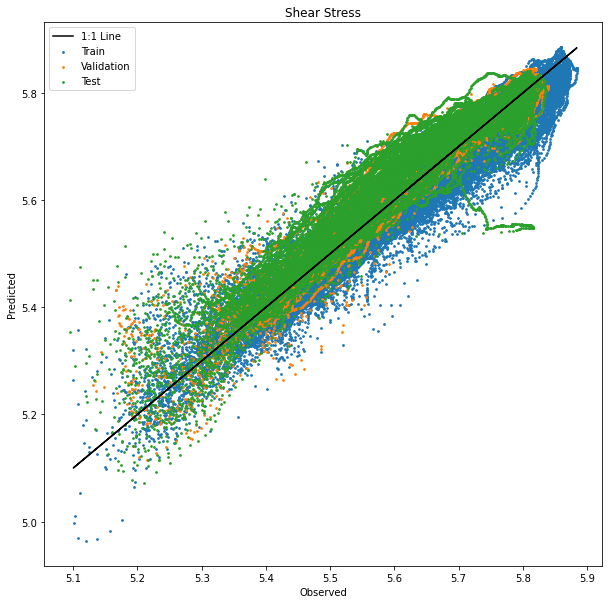

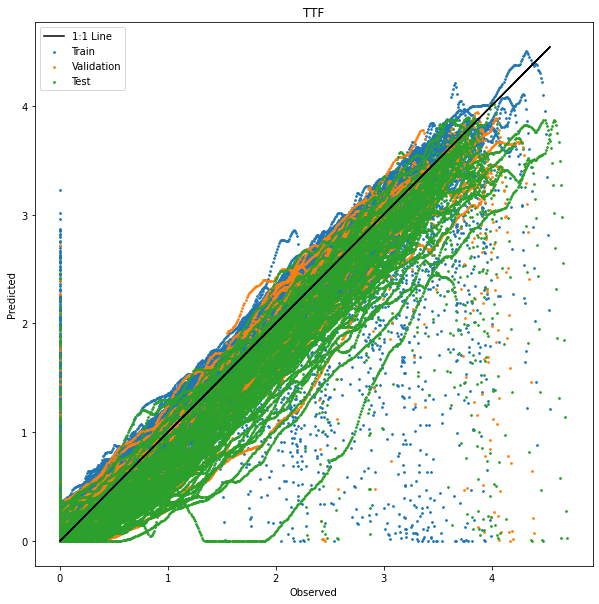

In [11]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train[:,0], Y_train[:,0], 'black')
plt.scatter(Y_train[:,0], y_predTrain[0], s=3)
plt.scatter(Y_val[:,0], y_predVal[0], s=3)
plt.scatter(y_test[:,0], y_predTest[0], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')

fig = plt.figure(8, figsize=(10,10))
plt.plot(Y_train[:,1], Y_train[:,1], 'black')
plt.scatter(Y_train[:,1], y_predTrain[1], s=3)
plt.scatter(Y_val[:,1], y_predVal[1], s=3)
plt.scatter(y_test[:,1], y_predTest[1], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('TTF')
